# Predicting flight delays by weather data

The goal of this notebook is to present a comprehensive analysis conducted as part of the "Python for Data Scientists" course at ENSAE. This project  includes data collection, preprocessing, visualization, scraping and modeling. By combining exploratory analysis and machine learning, the notebook aims to provide actionable insights into how weather affects flight delays. We trained our model on data from JFK Airport during 2017. We created an application to test our model and make predictions for future or past flights. 

## Introduction

### Motivation

Flight delays are a common inconvenience for both passengers and airlines, and while many are attributed to operational or logistical issues, weather often plays a crucial role. However, understanding and predicting these delays using weather data alone poses significant challenges.

This project seeks to address the following key questions:
- How do weather conditions correlate with flight delays?
- Can weather data reliably predict delays?
- What are the limitations of weather-based predictive models in this context?

We also wanted to make our model more dynamic, so we created an application with a very simple design. You just need to type your flight number and the date of the flight. Weather data at the airport that day and a prediction about the delay will be displayed. Sometimes our model predicts negative delays: this should be interpreted as an advance (which usually does not happen because flight companies do not want the flight to leave earlier than planned). 

### Executive summary

By merging data from the Bureau of Transportation Statistics and IBM Weather data, we were able to train several machine learning algorithms. To do so, we cleaned the data according to some hypotheses we made by ourselves (the list is below) The most performing model was a linear regression with the following variables having the most impact on delays: VARIABLES. However, this model performs poorly. The errors and precision statistics are: VALUES. Despite this, the values predicted by our application using data from SOURCE are somehow coherent. The exploratory data analysis maybe revealed the source of error: the quality of the data we used to train our model might be of poor quality. Many delays were missing and replaced by 0. Another possibility is that, nowadays, plane are very resistant to weather conditions. Other sources of delays should be explored. 

Ideas to explore: 
- Other Machine Learning models like Time Series. 
- We decided to focus on departure delays and not arrival delay as a simplifying procedure: we did not posses enough time our ressources to track the weather during the entire flight, which undermines the precision of our model.

### Data collection:

On the web, we found two useful datasets to build our algorithm.
1. **Plane data**:
   - **[Bureau of Transportation Statistics](https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr)**: Dataset containing detailed information about flights, like delays and destinations. The website interface enables to download precisely the data we want, from the variables to the period of time considered (year and month). We decided to restrict ourselves to download the data from the year 2017 only, as it takes a lot of time to download a dataset for a single month. 

2. **Weather data**:
   - **[IBM Weather Data](https://developer.ibm.com/exchanges/data/all/jfk-weather-data/)**: Weather data from JFK airport during the year 2017

### List of hypotheses

1. A plane's delays are similarly sensitive to weather variations. We can generalize the situation for an airport to others
2. We can replaces the missing values for delays by 0 because we suppose that a delay is more likely to be registered than no delay as it creates more frustration
3. 'T' is used to indicate a quantity observed was too low to be measured, we assume it is equal to zero
4. The weather is the same for each 30-min interval of time


### Structure of the project

1. Data Cleaning
2. Exploratory Data Analysis
3. Modeling (ML)
4. Interpretation and Insights
5. Application that predicts flight delays with the previous models
6. Conclusion

### Installations and Prerequisites

Before running the notebook, ensure that the required Python modules are installed to guarantee smooth execution of the code. Execute the following command in your terminal or notebook cell to install the necessary libraries:

In [3]:
%pip install openpyxl
%pip install openpyxl

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Importing Useful Modules

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import io
import os
import numpy as np
from datetime import timedelta
import seaborn as sns
import matplotlib.dates as mdates
import s3fs
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from math import sqrt

## Part 1: Data cleaning

First, we download the files from leoacpr by typing the SSP Cloud username. Please note that this can take a while because the files are heavy. The cells were hidden to guarantee a better readability of the notebook. Feel free to explore the code to generate the data. We relied on Amazon S3 provided by Onyxia SSP Cloud to store our data. We created different dataframes and the end of the preprocessing step. 
-	Plane_weather contains all the useful data to explore the variables and it contains the time of departure and the time of weather recording. 
-	Plane_weather_for_ML contains the same data without the time columns. This dataframe can directly be used for machine learning algorithms as all the columns are of type float. 


In [5]:
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

MY_BUCKET = "leoacpr"
source_folder = f"{MY_BUCKET}/diffusion/Pre-processing"

YOUR_BUCKET = str(input("Type your bucket: \n"))

source_folder = f"{MY_BUCKET}/diffusion/Pre-processing"
files_in_source = fs.ls(source_folder)

# Copying the dataframe from leoacpr to your s3 database
for file_path_in_s3 in files_in_source:
    file_name = file_path_in_s3.split('/')[-1]  # Name of the file without the path

    # If the file already exists in your database, then it won't download it
    if fs.ls(f"{MY_BUCKET}/diffusion/Pre-processing") != fs.ls(f"{YOUR_BUCKET}/diffusion/Pre-processing"):
        file_path_for_you = f"{YOUR_BUCKET}/diffusion/Pre-processing/{file_name}"
        #import
        with fs.open(file_path_in_s3, "r") as file_in:
            df_imported = pd.read_csv(file_in)
        #export
        with fs.open(file_path_for_you, "w") as file_out:
            df_imported.to_csv(file_out)
        
        print(f"File {file_name} has been successfully copied to {file_path_for_you}")

#Create folders inside S3
if not fs.exists(f"{YOUR_BUCKET}/diffusion/Pre-processed_data"):
    fs.touch(f"{YOUR_BUCKET}/diffusion/Pre-processed_data")

#Downloading the dataframes
dataframes = {}

for files in fs.ls(f"{YOUR_BUCKET}/diffusion/Pre-processing"):
    with fs.open(files, "r") as file_in:
            df_imported = pd.read_csv(file_in)
            print(f"Downloading {files}")
    # Dictionnary of dataframes with the name of the file as a key
    dataframes[f"{files.split('/')[-1]}"] = df_imported


File T_ONTIME_REPORTING_april.csv has been successfully copied to leo/diffusion/Pre-processing/T_ONTIME_REPORTING_april.csv
File T_ONTIME_REPORTING_august.csv has been successfully copied to leo/diffusion/Pre-processing/T_ONTIME_REPORTING_august.csv
File T_ONTIME_REPORTING_december.csv has been successfully copied to leo/diffusion/Pre-processing/T_ONTIME_REPORTING_december.csv
File T_ONTIME_REPORTING_february.csv has been successfully copied to leo/diffusion/Pre-processing/T_ONTIME_REPORTING_february.csv
File T_ONTIME_REPORTING_january.csv has been successfully copied to leo/diffusion/Pre-processing/T_ONTIME_REPORTING_january.csv
File T_ONTIME_REPORTING_july.csv has been successfully copied to leo/diffusion/Pre-processing/T_ONTIME_REPORTING_july.csv
File T_ONTIME_REPORTING_june.csv has been successfully copied to leo/diffusion/Pre-processing/T_ONTIME_REPORTING_june.csv
File T_ONTIME_REPORTING_march.csv has been successfully copied to leo/diffusion/Pre-processing/T_ONTIME_REPORTING_marc

/tmp/ipykernel_119848/446037297.py:20: DtypeWarning: Columns (10,12,13,14,15,16,17,18,19,22,24,25,27,42,65,66,69,70,71,86,87,88,89) have mixed types. Specify dtype option on import or set low_memory=False.
  df_imported = pd.read_csv(file_in)


File jfk_weather.csv has been successfully copied to leo/diffusion/Pre-processing/jfk_weather.csv


/tmp/ipykernel_119848/446037297.py:36: DtypeWarning: Columns (11,13,14,15,16,17,18,19,20,23,25,26,28,43,66,67,70,71,72,87,88,89,90) have mixed types. Specify dtype option on import or set low_memory=False.
  df_imported = pd.read_csv(file_in)


To help us clean the data, we create a function that displays the columns with missing data. 

In [6]:
def check_nan_columns(df):
    """Checks and prints the columns containing NaN values

    Args:
        df (pd.dataframe): a dataframe
    """

    nan_columns = df.columns[df.isna().any()].tolist()
    for col in nan_columns:
        nan_count = df[col].isna().sum()
        print(f"Colonne '{col}' contient {nan_count} valeurs NaN.")

### Pre-processing the planes data



In [7]:
#Merging the monthly datasets to obtain a dataset for 2017
january_JFK = dataframes['T_ONTIME_REPORTING_january.csv'][lambda df: df["ORIGIN_AIRPORT_ID"] == 10135] 
february_JFK = dataframes['T_ONTIME_REPORTING_february.csv'][lambda df: df["ORIGIN_AIRPORT_ID"] == 10135] 
march_JFK = dataframes['T_ONTIME_REPORTING_march.csv'][lambda df: df["ORIGIN_AIRPORT_ID"] == 10135] 
april_JFK = dataframes['T_ONTIME_REPORTING_april.csv'][lambda df: df["ORIGIN_AIRPORT_ID"] == 10135] 
may_JFK = dataframes['T_ONTIME_REPORTING_may.csv'][lambda df: df["ORIGIN_AIRPORT_ID"] == 10135] 
june_JFK = dataframes['T_ONTIME_REPORTING_june.csv'][lambda df: df["ORIGIN_AIRPORT_ID"] == 10135] 
july_JFK = dataframes['T_ONTIME_REPORTING_july.csv'][lambda df: df["ORIGIN_AIRPORT_ID"] == 10135] 
august_JFK = dataframes['T_ONTIME_REPORTING_august.csv'][lambda df: df["ORIGIN_AIRPORT_ID"] == 10135] 
september_JFK = dataframes['T_ONTIME_REPORTING_september.csv'][lambda df: df["ORIGIN_AIRPORT_ID"] == 10135] 
october_JFK = dataframes['T_ONTIME_REPORTING_october.csv'][lambda df: df["ORIGIN_AIRPORT_ID"] == 10135] 
november_JFK = dataframes['T_ONTIME_REPORTING_november.csv'][lambda df: df["ORIGIN_AIRPORT_ID"] == 10135] 
december_JFK = dataframes['T_ONTIME_REPORTING_december.csv'][lambda df: df["ORIGIN_AIRPORT_ID"] == 10135] 
#Total size = 2138
year = [january_JFK, february_JFK, march_JFK, april_JFK, may_JFK, june_JFK, july_JFK, august_JFK, september_JFK, october_JFK, november_JFK, december_JFK]
JFK_2017 = pd.concat(year, ignore_index=True)
JFK_2017.drop(columns=['Unnamed: 0'], inplace=True)
#print(JFK_2017)

#Setting the rights data types
#print(JFK_2017.info())
JFK_2017['FL_DATE'] = pd.to_datetime(JFK_2017['FL_DATE'])

#Hypothesis : we can replaces the missing values for delays by 0 because we suppose that a delay is more likely to be registered than no delay because it creates more frustration
JFK_2017['WEATHER_DELAY'] = JFK_2017['WEATHER_DELAY'].fillna(0)
JFK_2017['DEP_DELAY'] = JFK_2017['DEP_DELAY'].fillna(0)
JFK_2017['CARRIER_DELAY'] = JFK_2017['CARRIER_DELAY'].fillna(0)
JFK_2017['WEATHER_DELAY'] = JFK_2017['WEATHER_DELAY'].fillna(0)
JFK_2017['ARR_DELAY'] = JFK_2017['ARR_DELAY'].fillna(0)

#Removing NaN per rows
check_nan_columns(JFK_2017)
#'DEP_TIME' has 36  NaN.
#'ARR_TIME' has 39 valeurs NaN.
JFK_2017 = JFK_2017.dropna(axis=0)
check_nan_columns(JFK_2017) #nothing --> no more NaN
#print(len(JFK_2017)) 
#1919

#Combining departure time information to obtain a column with year, month, day, hour, minute for departure
#'DEP_TIME' contains str with numbers indicating the hours and minutes through the format "hhmm"
JFK_2017['DEP_TIME'] = JFK_2017['DEP_TIME'].astype(str).str.replace(r'\.0$', '', regex=True)
JFK_2017['DEP_TIME'] = JFK_2017['DEP_TIME'].astype(str).str.zfill(4)  # Ensure it's 4 digits
JFK_2017['Hours'] = JFK_2017['DEP_TIME'].str[:2].astype(int)  # Get hours as integer
JFK_2017['Minutes'] = JFK_2017['DEP_TIME'].str[2:].astype(int)  # Get minutes as integer
JFK_2017['departure_time'] = pd.to_timedelta(JFK_2017['Hours'], unit='h') + pd.to_timedelta(JFK_2017['Minutes'], unit='m')
JFK_2017['Full_Departure_Datetime'] = JFK_2017['FL_DATE'] + JFK_2017['departure_time']
JFK_2017.drop(['Hours', 'Minutes', 'departure_time'], axis=1, inplace=True)
#print(JFK_2017.head())

#Isolating the data for machine learning 
JFK_2017_no_number = JFK_2017[['Full_Departure_Datetime', 'FL_DATE','OP_UNIQUE_CARRIER','OP_CARRIER_AIRLINE_ID','OP_CARRIER','TAIL_NUM','OP_CARRIER_FL_NUM','ORIGIN_AIRPORT_ID','ORIGIN_AIRPORT_SEQ_ID','ORIGIN_CITY_MARKET_ID','DEST_AIRPORT_ID','DEST_CITY_MARKET_ID','DEST', 'DEP_TIME','ARR_TIME']]
JFK_2017_number = JFK_2017[['DEP_DELAY','ARR_DELAY','CANCELLED','CARRIER_DELAY','WEATHER_DELAY','Full_Departure_Datetime']]
JFK_2017_number['CANCELLED'] = JFK_2017_number['CANCELLED'].astype(int)
#print(JFK_2017_number.info())

#Exporting the dataset for JFK planes
with fs.open(f"{YOUR_BUCKET}/diffusion/Pre-processed_data/JFK_2017.csv", "w") as path:
    JFK_2017.to_csv(path)

with fs.open(f"{YOUR_BUCKET}/diffusion/Pre-processed_data/JFK_2017_no_number.csv", "w") as path:
    JFK_2017_no_number.to_csv(path)

with fs.open(f"{YOUR_BUCKET}/diffusion/Pre-processed_data/JFK_2017_number.csv", "w") as path:
    JFK_2017_number.to_csv(path)


Colonne 'DEP_TIME' contient 38 valeurs NaN.
Colonne 'ARR_TIME' contient 41 valeurs NaN.


/tmp/ipykernel_119848/930485656.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  JFK_2017['FL_DATE'] = pd.to_datetime(JFK_2017['FL_DATE'])
/tmp/ipykernel_119848/930485656.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  JFK_2017_number['CANCELLED'] = JFK_2017_number['CANCELLED'].astype(int)


### Pre-processing the weather data


In [8]:
#We take only the data for the year 2017
weather = dataframes['jfk_weather.csv']
#print(weather.head())

weather['DATE'] = pd.to_datetime(weather['DATE'])
weather_2017 = weather[weather['DATE'].dt.year == 2017]
weather_2017 = weather_2017.loc[:, ~weather_2017.columns.str.startswith('Unnamed')]

#print(weather_2017.head())
#print(weather_2017.tail())
#print(weather.info()) 
#90 columns

#Columns with "Monthly", "Hourly" ou "Daily" contains only one value for the unit they represent.
# for example for a monthly columns, only the last day of the corresponding month contains a value
# We need to extend this

# Extracting the columns "Monthly", "Hourly" ou "Daily"
monthly_columns = [col for col in weather_2017.columns if 'Monthly' in col]
hourly_columns = [col for col in weather_2017.columns if 'HOURLY' in col]
daily_columns = [col for col in weather_2017.columns if 'DAILY' in col]

# Conversion in datetime type
weather_2017['YearMonth'] = weather_2017['DATE'].dt.to_period('M')  # Extraire l'année et le mois
weather_2017['YearDayHour'] = weather_2017['DATE'].dt.to_period('H')  # Extraire l'année, jour et heure
weather_2017['YearDay'] = weather_2017['DATE'].dt.to_period('D')  # Extraire l'année et jour

# Filling the NaN values
def fill_periodic_values(df, columns, period_key):
    for col in columns:
        if col in df.columns:
            # Utiliser les groupes par période pour remplir les NaN avec ffill et bfill
            df[col] = df.groupby(period_key)[col].transform(lambda group: group.ffill().bfill())

fill_periodic_values(weather_2017, monthly_columns, 'YearMonth')
fill_periodic_values(weather_2017, daily_columns, 'YearDay')
fill_periodic_values(weather_2017, hourly_columns, 'YearDayHour')

# Deleting the temporary columns
weather_2017.drop(columns=['YearMonth', 'YearDayHour', 'YearDay'], inplace=True)


# Veryfying other columns with NaN
     
# Some variables have value -9999 instead of NaN
# We replace them by NaN to remove them later
weather_2017 = weather_2017.replace(-9999, np.nan)

check_nan_columns(weather_2017)

# We remove the columns containg more than 1000 NaN values
weather_2017 = weather_2017.dropna(axis=1, thresh=len(weather_2017) - 1000)
check_nan_columns(weather_2017)
#print(len(weather_2017)) #13201
weather_2017 = weather_2017.dropna(axis=0)
check_nan_columns(weather_2017) #nothing
#print(len(weather_2017)) #13027


#Deletion of useless columns (because of weather encoding standards (str whose meaning is not easily retrievable), complex units like angles, no variance, etc...)
inutile = ['STATION','STATION_NAME','ELEVATION','LATITUDE','LONGITUDE', 'REPORTTPYE', 'HOURLYSKYCONDITIONS', 'HOURLYWindDirection', 'MonthlyDaysWithLT0Temp', 'DAILYSustainedWindDirection']
weather_2017.drop(columns=inutile, inplace=True)

#Hyptohesis: 'T' is used to indicate a quantity observed was too low to be measured, we assume it is equal to zero
weather_2017 = weather_2017.replace('T', 0)

#Some variables have values equal to a number followed by a character, we keep only the number by using regex
for col in weather_2017.columns:
    weather_2017[col] = weather_2017[col].replace(r'(\d+(\.\d+)?)([^\d\s]+)$', r'\1', regex=True)


# We delete columns that represents the same thing but with different units (like celsius VS Farenheit)
# we keep Fahrenheit because some variables do not have the celsius equivalent (American weather)
Celsius = ['HOURLYDRYBULBTEMPC', 'HOURLYWETBULBTEMPC', 'HOURLYDewPointTempC']
weather_2017.drop(columns=Celsius, inplace=True)

#We set all variables to be float, expect time
#delete the two first columns because it starts with Unnamed 0 and DATE to convert the rest to float
weather_2017 = pd.concat([weather_2017[['DATE']], weather_2017.iloc[:, 1:].astype(float)], axis=1)

#print(weather_2017.info())
#print(weather_2017.head())

with fs.open(f"{YOUR_BUCKET}/diffusion/Pre-processed_data/weather_2017.csv", "w") as path:
    weather_2017.to_csv(path)

/tmp/ipykernel_119848/4007371469.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather_2017['YearDayHour'] = weather_2017['DATE'].dt.to_period('H')  # Extraire l'année, jour et heure
/tmp/ipykernel_119848/4007371469.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df.groupby(period_key)[col].transform(lambda group: group.ffill().bfill())


Colonne 'HOURLYSKYCONDITIONS' contient 5 valeurs NaN.
Colonne 'HOURLYVISIBILITY' contient 5 valeurs NaN.
Colonne 'HOURLYPRSENTWEATHERTYPE' contient 10553 valeurs NaN.
Colonne 'HOURLYWETBULBTEMPF' contient 13 valeurs NaN.
Colonne 'HOURLYWETBULBTEMPC' contient 13 valeurs NaN.
Colonne 'HOURLYDewPointTempF' contient 4 valeurs NaN.
Colonne 'HOURLYDewPointTempC' contient 4 valeurs NaN.
Colonne 'HOURLYRelativeHumidity' contient 4 valeurs NaN.
Colonne 'HOURLYWindGustSpeed' contient 11048 valeurs NaN.
Colonne 'HOURLYStationPressure' contient 9 valeurs NaN.
Colonne 'HOURLYPressureTendency' contient 4379 valeurs NaN.
Colonne 'HOURLYPressureChange' contient 7324 valeurs NaN.
Colonne 'HOURLYSeaLevelPressure' contient 2 valeurs NaN.
Colonne 'HOURLYPrecip' contient 5 valeurs NaN.
Colonne 'DAILYAverageRelativeHumidity' contient 1415 valeurs NaN.
Colonne 'DAILYAverageDewPointTemp' contient 1016 valeurs NaN.
Colonne 'DAILYAverageWetBulbTemp' contient 1016 valeurs NaN.
Colonne 'DAILYWeather' contient 614

### Merging the dataset

Then, we merge the two datasets, and export specific dataframes for Data Exploration and Machine Learning

In [9]:
# Conversion of data time to numpy.datetime64 type to accelerate comparisons 
departure_times = JFK_2017_number['Full_Departure_Datetime'].values.astype('datetime64[m]')  # minutes
weather_times = weather_2017['DATE'].values.astype('datetime64[m]')  # minutes

#Hypothesis: the weather is the same for each 30-min interval of time
tolerance = np.timedelta64(30, 'm')

merged_rows = []

#we want to find the minimum time difference between the plane departure and the measured weather
for departure_time in departure_times:
    time_differences = np.abs(departure_time - weather_times)
    closest_index = np.argmin(time_differences)
    
    # If the time difference is beow the tolerance, we combine the information from JFK_numbers and weather_2017
    if time_differences[closest_index] <= tolerance:
        closest_weather_row = weather_2017.iloc[closest_index]
        jfk_row = JFK_2017_number.iloc[np.where(departure_times == departure_time)[0][0]]  # find the corresponding row
        merged_row = pd.concat([jfk_row, closest_weather_row], axis=0)
        merged_rows.append(merged_row)

# Combining all the rows that were accepted
merged_df = pd.DataFrame(merged_rows, columns=np.concatenate([JFK_2017_number.columns, weather_2017.columns]))

#print(merged_df['Full_Departure_Datetime'])
#only about 10 rows were lost for a tolerance of 30min: acceptable 

# Uploading the data
merged_df.rename(columns={'DATE': 'DATE_weather'}, inplace=True)
with fs.open(f"{YOUR_BUCKET}/diffusion/Pre-processed_data/plane_weather.csv", "w") as path:
    merged_df.to_csv(path)

check_nan_columns(merged_df)
#print(merged_df.info())

plane_weather_for_ML = merged_df.drop(columns=['Full_Departure_Datetime', 'DATE_weather'])
with fs.open(f"{YOUR_BUCKET}/diffusion/Pre-processed_data/plane_weather_for_ML.csv", "w") as path:
    plane_weather_for_ML.to_csv(path)

#print(plane_weather_for_ML.info())

## Part 2: Exploratory statistics

In this part, we analyze how the different variables behave and how they are linked. The goal is to pave the way to machine learning. 
Download the files from leoacpr by typing the SSP Cloud username.
This can take a while because the files are heavy.

In [10]:
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

MY_BUCKET = "leoacpr"
source_folder = f"{MY_BUCKET}/diffusion/Pre-processing"
files_in_source = fs.ls(source_folder)

#Downloading the dataframes
dataframes = {}

for files in fs.ls(f"{MY_BUCKET}/diffusion/Pre-processed_data"):
    with fs.open(files, "r") as file_in:
            df_imported = pd.read_csv(file_in)
            print(f"Downloading {files}")
    # Dictionnary of dataframes with the name of the file as a key
    dataframes[f"{files.split('/')[-1]}"] = df_imported

#Load the data and remove useless columns
plane_weather = dataframes['plane_weather.csv']
plane_weather_for_ML = dataframes['plane_weather_for_ML.csv']
JFK_2017_number = dataframes['JFK_2017_number.csv']
weather_2017 = dataframes['weather_2017.csv']
plane_weather.drop(columns=['Unnamed: 0'], inplace=True)
plane_weather_for_ML.drop(columns=['Unnamed: 0'], inplace=True)
JFK_2017_number.drop(columns=['Unnamed: 0'], inplace=True)
weather_2017.drop(columns=['Unnamed: 0'], inplace=True)

plane_weather['Full_Departure_Datetime'] = pd.to_datetime(plane_weather['Full_Departure_Datetime'])
plane_weather['DATE_weather'] = pd.to_datetime(plane_weather['DATE_weather'])


### Step 1: General behavior of the variables

#### Mean delays per month
Departure delays are in general more pronounced than arrival delays. We notice the mean departure delays are higher in winter, especially in January and December. As for April, a deeper analysis showed that the peak is mostly explained by an outlier.

[]

<Figure size 1000x600 with 0 Axes>

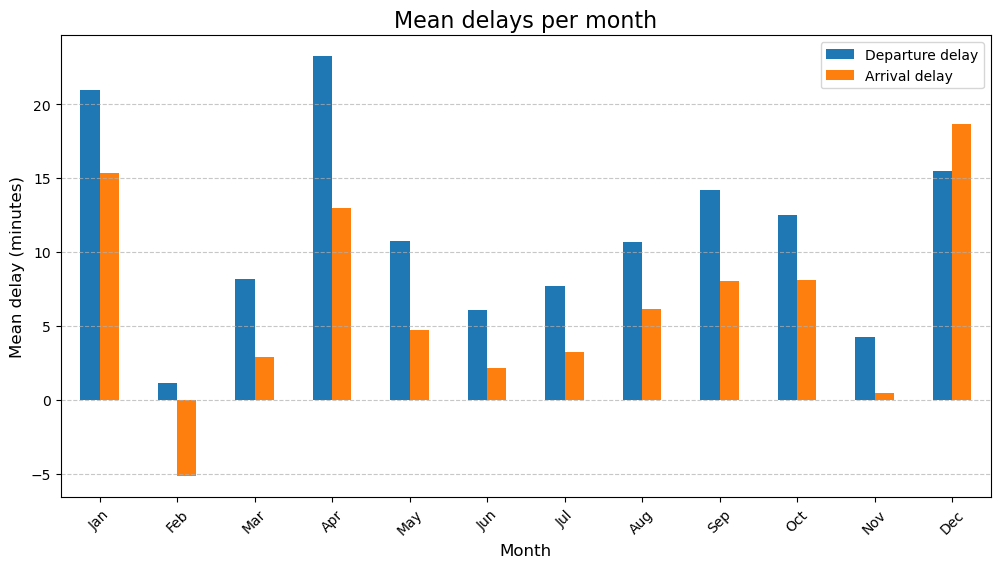

In [11]:
plane_weather['Month'] = plane_weather['Full_Departure_Datetime'].dt.month
monthly_delays = plane_weather.groupby('Month')[['DEP_DELAY', 'ARR_DELAY']].mean()
plt.figure(figsize=(10, 6))
monthly_delays.plot(kind='bar', figsize=(12, 6))
plt.title("Mean delays per month", fontsize=16)
plt.ylabel("Mean delay (minutes)", fontsize=12)
plt.xlabel("Month", fontsize=12)
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.legend(["Departure delay", "Arrival delay"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.savefig('Avions-Retard-et-Meteo/2_Data_exploration/pictures/1_mean_delays.png')
plt.plot()

#### Distribution of departure delays

Our hypothesis that missing delays values should be replaced by zero enabled us to work on the data but at a certain cost: we see that the distribution of delays clearly shows a peak for delays with very small values. Bigger values exist but they are much scarcer. Most flights’ departures are on time or with a negligible delay, most of which are equal to zero. Most delays are of a duration of two hours or less, suggesting that weather-related delays are likely due to slightly unfavorable weather conditions (such as waiting for the rain to lessen before taking off), rather than extremely unfavorable conditions (like an exceptional storm), which is consistent with the relative frequency of these two types of events. Among the recorded delays, very few are attributed to weather conditions, and all of these are very short delays (less than 30 minutes), which aligns with the previous observation. These weather-related delays are concentrated in certain months of the year: January, March, August, September, October, and December. January, September, and December are indeed months with numerous delays (for all reasons), but this is not the case for March, August, and October. Therefore, the overall volume of delays seems decoupled from the volume of weather-related delays, which may be linked to the small amount of weather-related delay data. In fact, the total minutes of delay caused by weather is low: it reaches a maximum of 700 minutes in December, which is very low given the large number of flights departing and arriving in December.

[]

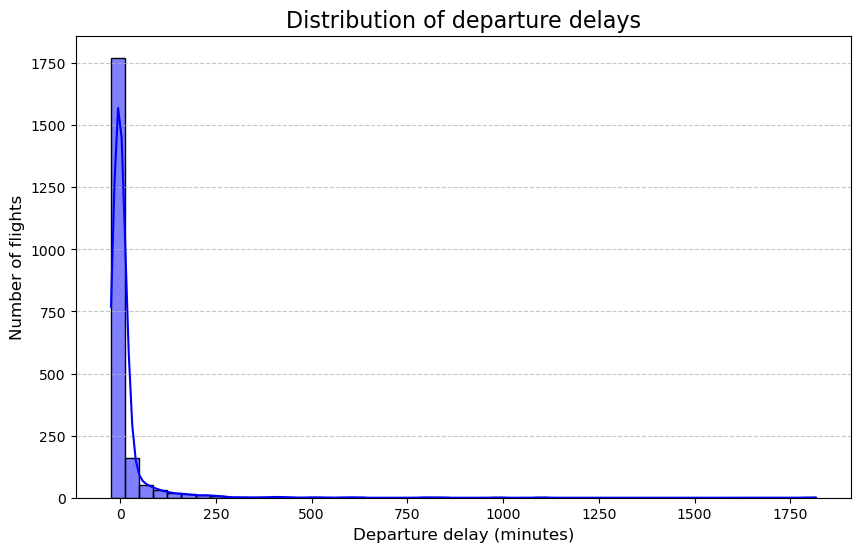

In [12]:
plt.figure(figsize=(10, 6))
sns.histplot(plane_weather['DEP_DELAY'], bins=50, kde=True, color='blue', edgecolor='black')
plt.title("Distribution of departure delays", fontsize=16)
plt.xlabel("Departure delay (minutes)", fontsize=12)
plt.ylabel("Number of flights", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.savefig('Avions-Retard-et-Meteo/2_Data_exploration/pictures/2_distribution_delays.png')
plt.plot()

#### Sum of weather delays per month

Several trials showed that the best way to visualize delays in this dataset was to consider their sum per month. December accumulates the most delays. This might be caused by the apparition of winter. Moreover, we see that August and September have also a lot of delays. Maybe it is an effect of denser air traffic (at this time of the year, with December, many people travel). 

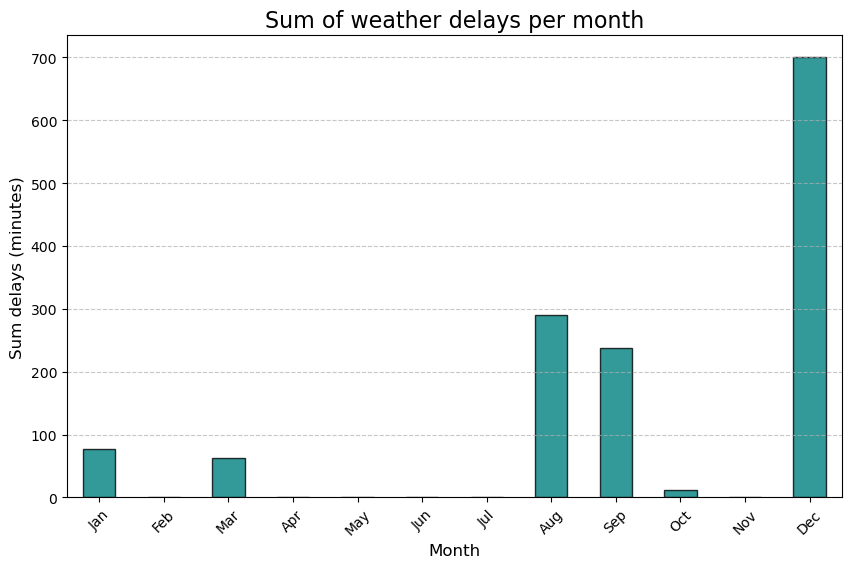

In [14]:
weather_delay_monthly = plane_weather.groupby('Month')['WEATHER_DELAY'].sum()
plt.figure(figsize=(10, 6))
weather_delay_monthly.plot(kind='bar', color='teal', alpha=0.8, edgecolor='black')
plt.title("Sum of weather delays per month", fontsize=16)
plt.ylabel("Sum delays (minutes)", fontsize=12)
plt.xlabel("Month", fontsize=12)
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.savefig('Avions-Retard-et-Meteo/2_Data_exploration/pictures/4_sum_weather_delays.png')
plt.show()
plane_weather.drop(columns=['Month'], inplace=True)

#### Proportions of delays

The plane dataset showed several categories of departure delays: carrier delay, weather delay and unexplained delay (that can be inferred from the first two categories and the variable DEP_DELAY). Delays explained by the weather account for only 0.8% of delays, but it is noteworthy that 95.3% of delays are unexplained, probably due to incomplete recording. This is why it seems interesting to ask whether there is a link between weather conditions and delays, as some delays are actually related to the weather may not have been recorded as such (they might have been left unexplained). This diagrams confirms our idea of exploring in more detail the relation between weather and delays. However, this also tells us that maybe the model we will train will be poorly explanatory. 

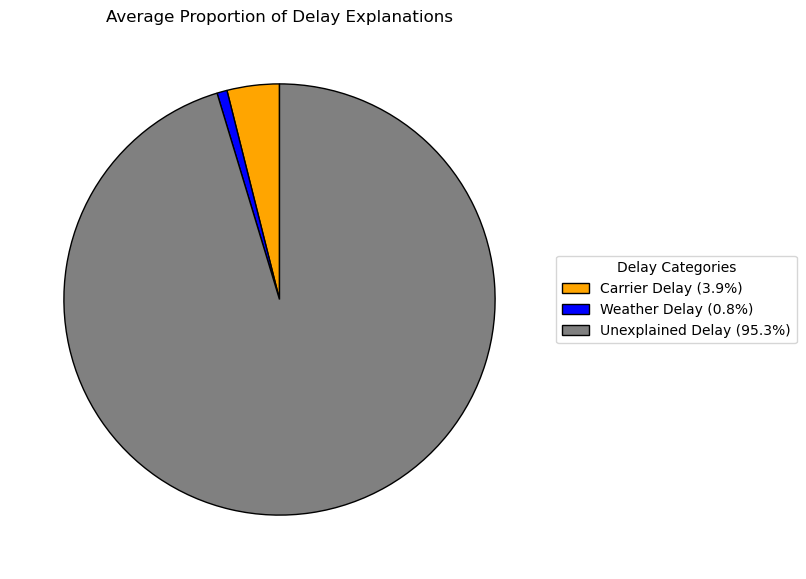

In [15]:
# Calculate the ratio of delays explained by CARRIER_DELAY, WEATHER_DELAY, and unexplained delays
plane_weather['carrier_delay_ratio'] = plane_weather['CARRIER_DELAY'] / plane_weather['DEP_DELAY']
plane_weather['weather_delay_ratio'] = plane_weather['WEATHER_DELAY'] / plane_weather['DEP_DELAY']
plane_weather['unexplained_delay_ratio'] = 1 - (plane_weather['carrier_delay_ratio'] + plane_weather['weather_delay_ratio'])

# Calculate the mean proportion of each type of delay
mean_carrier_delay = plane_weather['carrier_delay_ratio'].mean()
mean_weather_delay = plane_weather['weather_delay_ratio'].mean()
mean_unexplained_delay = plane_weather['unexplained_delay_ratio'].mean()

sizes = [mean_carrier_delay, mean_weather_delay, mean_unexplained_delay]
labels = ['Carrier Delay', 'Weather Delay', 'Unexplained Delay']
colors = ['orange', 'blue', 'gray']

plt.figure(figsize=(11, 7))
wedges, texts = plt.pie(sizes, colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'}, labels=None)
percentages = [f'{size / sum(sizes) * 100:.1f}%' for size in sizes]
legend_labels = [f'{label} ({percentage})' for label, percentage in zip(labels, percentages)]
plt.title('Average Proportion of Delay Explanations')
plt.legend(wedges, legend_labels, title="Delay Categories", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=10)
plt.title('Average Proportion of Delay Explanations')
#plt.savefig('Avions-Retard-et-Meteo/2_Data_exploration/pictures/5_Proportions_of_delays.png')
plt.plot()
plane_weather = plane_weather.drop(columns=['carrier_delay_ratio', 'weather_delay_ratio', 'unexplained_delay_ratio'])

#### Weather trends for the year 2017

The plot reveals that the weather around JFK airport is quite normal. No extreme weather conditions were recorded. This could undermine the generalization of our model as it has never seen such events. That is why we recommend using our model on airports with similar weather conditions. 

[]

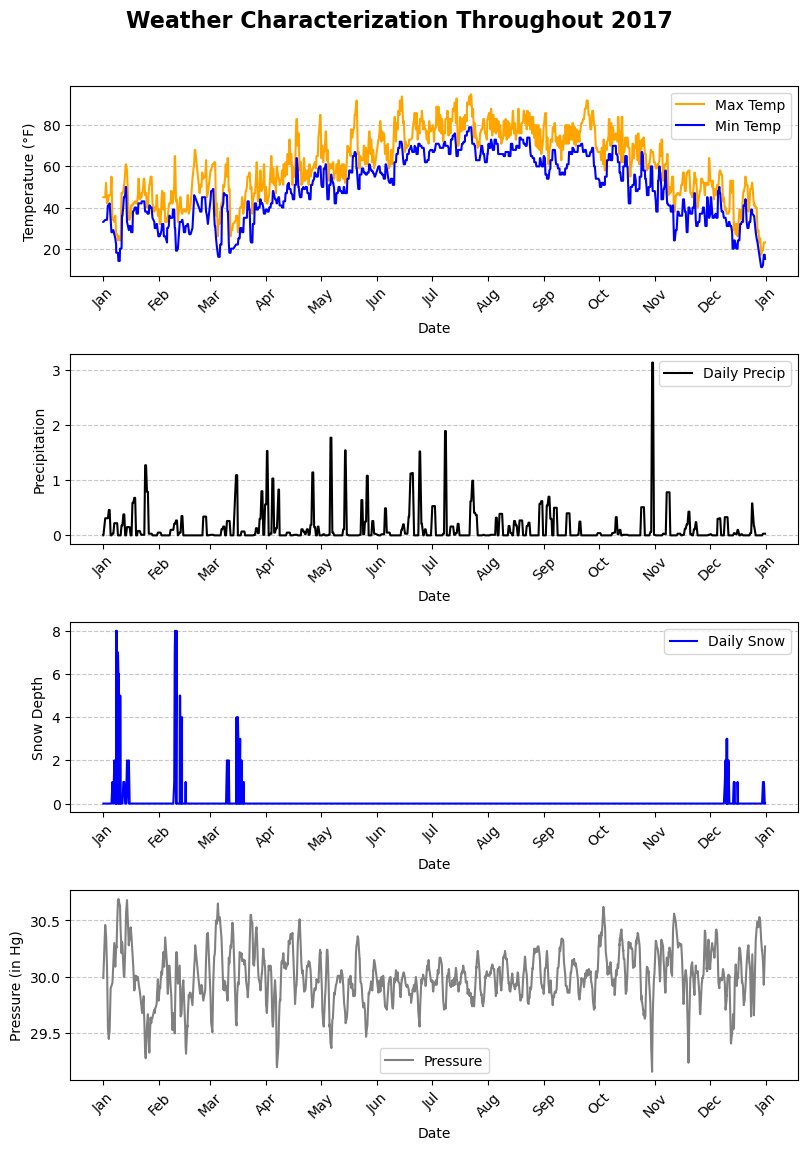

In [16]:
plt.figure(figsize=(8.27, 11.69))  # A4 size (in inches)
plt.suptitle('Weather Characterization Throughout 2017', fontsize=16, fontweight='bold')

# Function to format subplots
def format_subplot(ax, data, x_column, y_column, label, color, ylabel):
    sns.lineplot(data=data, x=x_column, y=y_column, label=label, color=color, ax=ax)
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # Display months
    ax.xaxis.set_major_locator(mdates.MonthLocator())  # Tick every month
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels

ax1 = plt.subplot(4, 1, 1)
format_subplot(ax1, plane_weather, 'Full_Departure_Datetime', 'DAILYMaximumDryBulbTemp', 'Max Temp', 'orange', 'Temperature (°F)')
sns.lineplot(data=plane_weather, x='Full_Departure_Datetime', y='DAILYMinimumDryBulbTemp', label='Min Temp', color='blue', ax=ax1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
ax2 = plt.subplot(4, 1, 2)
format_subplot(ax2, plane_weather, 'Full_Departure_Datetime', 'DAILYPrecip', 'Daily Precip', 'black', 'Precipitation')
plt.grid(axis='y', linestyle='--', alpha=0.7)
ax3 = plt.subplot(4, 1, 3)
format_subplot(ax3, plane_weather, 'Full_Departure_Datetime', 'DAILYSnowDepth', 'Daily Snow', 'blue', 'Snow Depth')
plt.grid(axis='y', linestyle='--', alpha=0.7)
ax4 = plt.subplot(4, 1, 4)
format_subplot(ax4, plane_weather, 'Full_Departure_Datetime', 'HOURLYStationPressure', 'Pressure', 'gray', 'Pressure (in Hg)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to avoid title overlap
#plt.savefig('Avions-Retard-et-Meteo/2_Data_exploration/pictures/6_weather_2017_summary.png', dpi=300)
plt.plot()

#### Month by month weather

It is observed that the months with the most delays are also the months when the weather changes compared to the previous month. For example, the temperature drops sharply in December compared to November; precipitation is much higher in April than in March, while snowfall is much lower in April than in March; snowfall is much heavier in January than in December. Furthermore, January, April, and March are also months when atmospheric pressure variance is high. In contrast, in February and November (the months with the fewest delays), weather conditions are very similar to those of the previous months (except for an outlier in precipitation in November), which leads us to suggest that it might be possible to predict delays based on weather conditions, despite the lack of correlation. We believe the mistakes when recording the delays might have a role in this lack of correlation, that is why we would like to analyze the topic further thanks to machine learning tools.

/tmp/ipykernel_119848/1137478392.py:29: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout for title


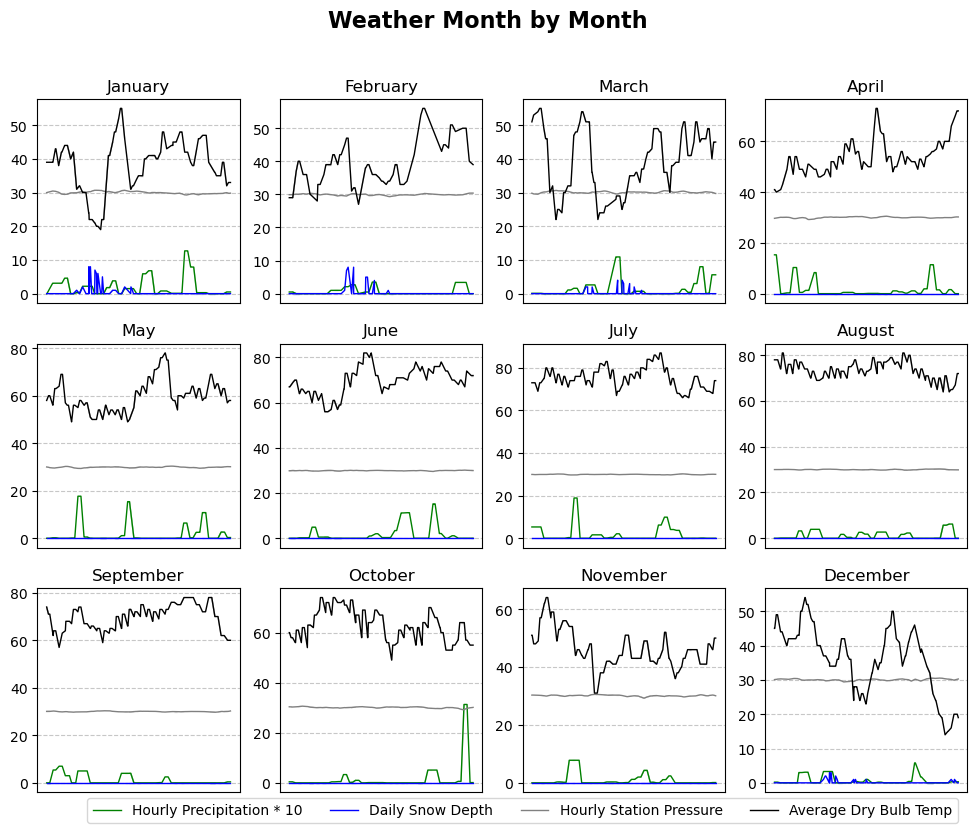

In [17]:
plt.figure(figsize=(12, 9))

# Function to format subplots
def format_subplot(ax, data, x_column, y_columns, labels, colors, ylabel):
    for y_col, label, color in zip(y_columns, labels, colors):
        sns.lineplot(data=data, x=x_column, y=y_col, label=label, color=color, ax=ax, linewidth=1)
    ax.set_ylabel(ylabel).set_visible(False)
    ax.legend().set_visible(False)
    ax.set_xlabel('')  # Delete x-axis label
    ax.xaxis.set_ticks([])  # Hide x-axis ticks

plane_weather['DAILYPrecip'] = plane_weather['DAILYPrecip']*10 #to show it more visibly on the graph
# List of months and corresponding colors
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
colors = ['green', 'blue', 'grey', 'black']
labels = ['Hourly Precipitation * 10', 'Daily Snow Depth', 'Hourly Station Pressure', 'Average Dry Bulb Temp']

# Loop over each month to create the subplots
for i, month in enumerate(months):
    month_data = plane_weather[plane_weather['DATE_weather'].dt.month == i + 1]
    ax = plt.subplot(3, 4, i+1)
    format_subplot(ax, month_data, 'DATE_weather', ['DAILYPrecip', 'DAILYSnowDepth', 'HOURLYStationPressure', 'DAILYAverageDryBulbTemp'], labels, colors, 'Values')
    ax.set_title(f'{month}')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
plt.suptitle('Weather Month by Month', fontsize=16, fontweight='bold')

plt.legend(loc='center', bbox_to_anchor=(-1.2, -0.09), ncol=4) 
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout for title

#plt.savefig('Avions-Retard-et-Meteo/2_Data_exploration/pictures/7_month_by_month.png', dpi=300)
plt.plot()

plane_weather['DAILYPrecip'] = plane_weather['DAILYPrecip']/10 #to remove the modification

### Step 2: Visualization of the variables interactions 

#### Correlation matrix

The correlation matrix shows very weak correlations between our variable of interest (DEP_DELAY) and weather variables. This can be explained by either non-linear relationships or by an absence of relation. We need to plot the interactions more precisely to study this. 

[]

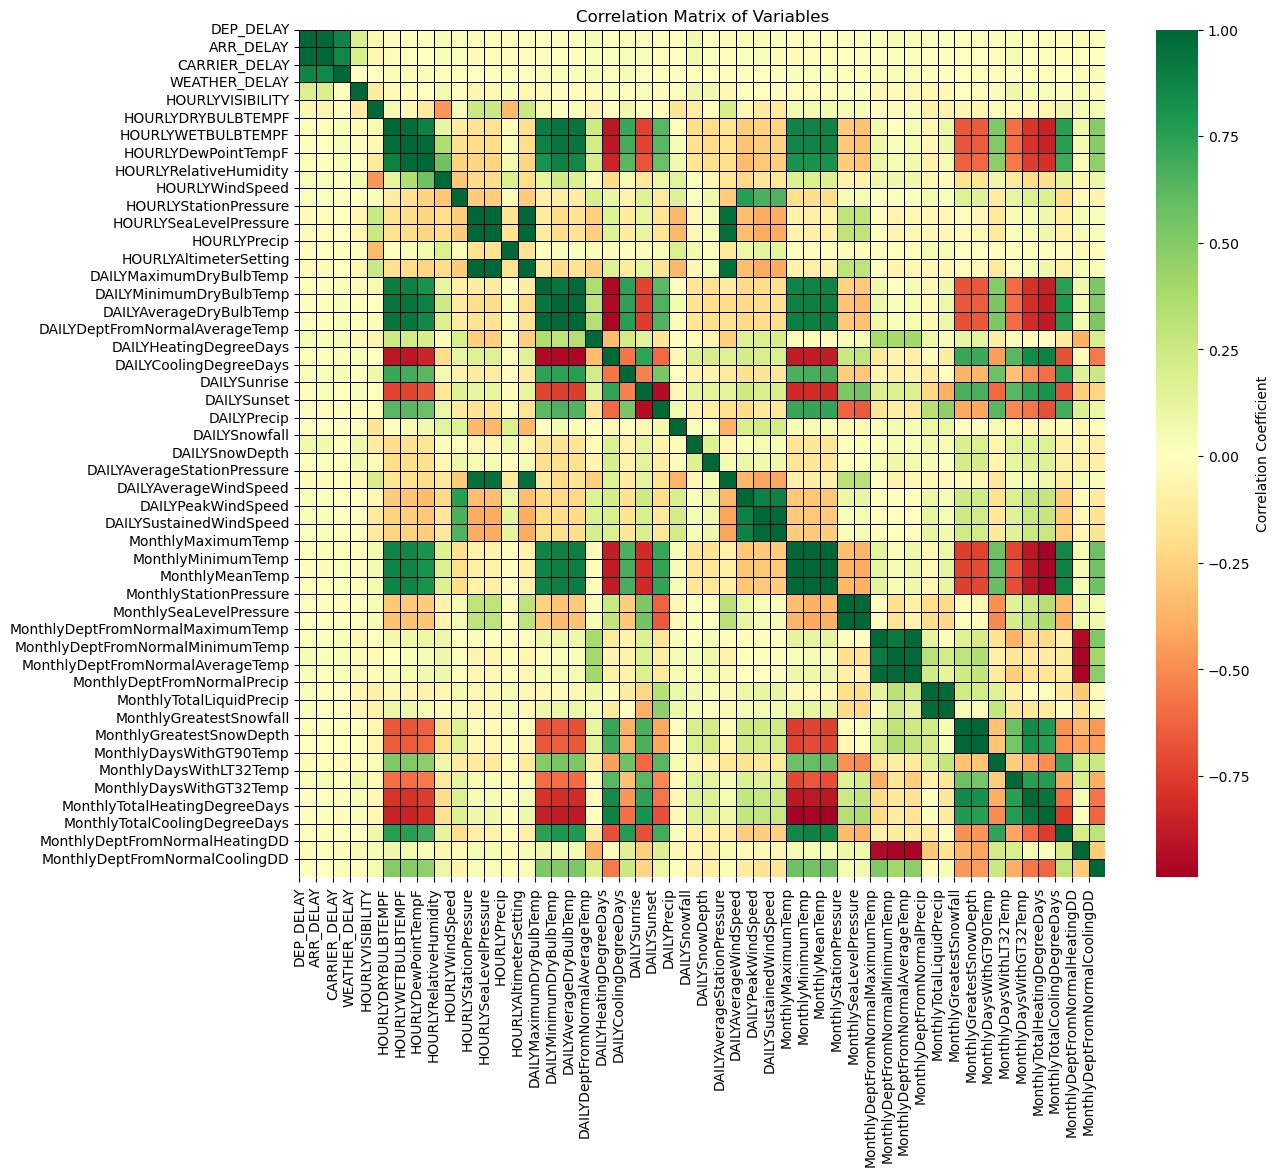

In [18]:
plane_weather_for_ML = plane_weather_for_ML.drop(columns=['CANCELLED'])
corr_matrix = plane_weather_for_ML.corr()
plt.figure(figsize=(13, 11))
sns.heatmap(corr_matrix, annot=False, cmap='RdYlGn', center=0, cbar_kws={'label': 'Correlation Coefficient'}, linewidths=0.4, linecolor='black')
ticks = np.arange(len(plane_weather_for_ML.columns))

plt.xticks(ticks=np.arange(len(plane_weather_for_ML.columns)), labels=plane_weather_for_ML.columns, rotation=90)
plt.yticks(ticks=np.arange(len(plane_weather_for_ML.columns)), labels=plane_weather_for_ML.columns, rotation=0)

plt.title('Correlation Matrix of Variables')
#plt.savefig('Avions-Retard-et-Meteo/2_Data_exploration/pictures/8_Corr_matrix.png', dpi=300)
plt.plot()

#### Scatter plots for the study of variables interactions

We plot several interactions between different variables, except the variables with strong correlation. Overall, the scatter plots seem to show an absence of relationship between the weather variables and DEP_DELAY. Building a highly explanatory model will prove to be difficult. 

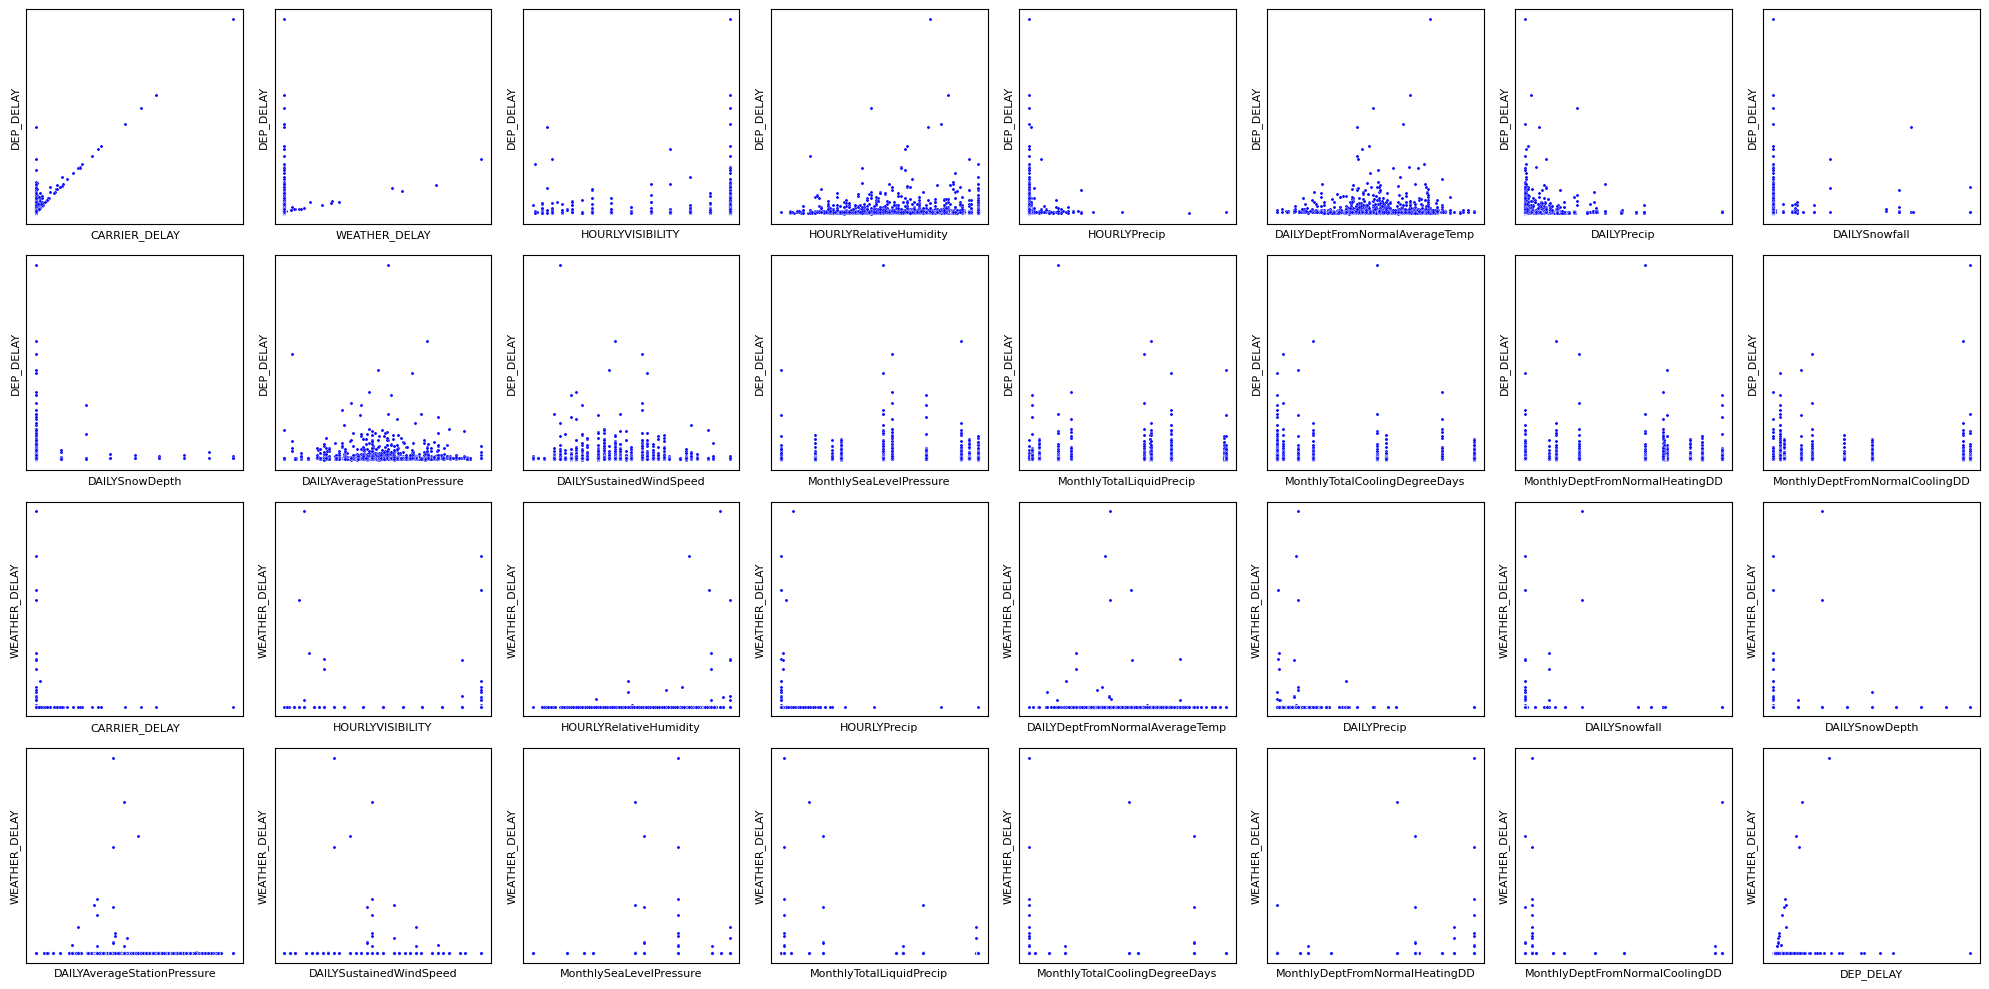

In [19]:
#Isolating the variables with a strong correlation
threshold = 0.7
strongly_correlated_pairs = []
variables_to_remove = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:  # Si la corrélation est au-dessus du seuil
            strongly_correlated_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
            variables_to_remove.add(corr_matrix.columns[j])

'''for pair in strongly_correlated_pairs:
    print(f'Variables: {pair[0]} & {pair[1]}, Corrélation: {pair[2]:.2f}')'''



#We remove some strongly correlated variables
#We remove cancel because it doesnt add any insight
variables_to_keep = [var for var in corr_matrix.columns if var not in variables_to_remove and var != 'CANCELLED']
variables_to_keep.append('DEP_DELAY') #we keep DEP_DELAY because this is the variable with the most information about delays
#print("\nVariables to keep :", variables_to_keep)



# We delete the useless variables in the dataframe
plane_weather_no_corr = plane_weather[variables_to_keep]
#print(plane_weather_no_corr) #18 variables


#looking for temporal relations --> machine learning / time series
plane_weather_reduced = pd.concat([plane_weather[['Full_Departure_Datetime']], plane_weather_no_corr], axis=1)
#print(plane_weather_reduced.info())



#Scatter plots:

# Variables of interest
variables_of_interest = ['DEP_DELAY', 'WEATHER_DELAY']

# Calculations for the grid
n_vars = len(variables_to_keep)
n_cols = 8 
n_rows = 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))

# Flatten axes for easier indexing
axes = axes.flatten()

# Counter for axes index
ax_idx = 0

# Generate scatter plots for DEP_DELAY and WEATHER_DELAY against other variables
for var in variables_of_interest:
    for other_var in [v for v in plane_weather_no_corr.columns if v != var]:
        sns.scatterplot(x=plane_weather_no_corr[other_var], 
                        y=plane_weather_no_corr[var], 
                        ax=axes[ax_idx], 
                        color='blue', s=5)
        
        axes[ax_idx].set_xlabel(other_var, fontsize=8)
        axes[ax_idx].set_ylabel(var, fontsize=8)
        axes[ax_idx].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        axes[ax_idx].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
        
        # Move to next axis
        ax_idx += 1

# Mask any remaining empty axes
for i in range(ax_idx, len(axes)):
    axes[i].axis('off')

plt.tight_layout()



#plt.savefig('Avions-Retard-et-Meteo/2_Data_exploration/pictures/9_Scatter_plot.png', dpi=300)
plt.show()

## Part 3: Machine Learning

### This part will include the following steps

1. **Initial Setup**:
   - Inclusion of all variables led to overfitting and unrealistic predictions, such as planes always being significantly ahead of or behind schedule.

2. **Feature Reduction**:
   - Iterative adjustments reduced features to the 8 most relevant variables, ensuring better balance between complexity and interpretability.

3. **Handling Correlation**:
   - Removal of one highly correlated variable (e.g., HOURLYStationPressure and HOURLYSeaLevelPressure) mitigated unrealistic predictions and improved consistency.

4. **Final Model**:
   - Linear Regression with 8 features selected via Feature Importance provided the best trade-off between errors (MAE, RMSE) and realistic predictions.


First, we load the data

In [20]:
#Download the files from leoacpr by typing the SSP Cloud username

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})

MY_BUCKET = "leoacpr"
source_folder = f"{MY_BUCKET}/diffusion/Pre-processing"
files_in_source = fs.ls(source_folder)


#Downloading the dataframes
dataframes = {}

for files in fs.ls(f"{MY_BUCKET}/diffusion/Pre-processed_data"):
    with fs.open(files, "r") as file_in:
            df_imported = pd.read_csv(file_in)
            print(f"Downloading {files}")
    # Dictionnary of dataframes with the name of the file as a key
    dataframes[f"{files.split('/')[-1]}"] = df_imported


#Load the data
plane_weather = dataframes['plane_weather.csv']
plane_weather_for_ML = dataframes['plane_weather_for_ML.csv']
JFK_2017_number = dataframes['JFK_2017_number.csv']
weather_2017 = dataframes['weather_2017.csv']
plane_weather.drop(columns=['Unnamed: 0'], inplace=True)
plane_weather_for_ML.drop(columns=['Unnamed: 0'], inplace=True)
JFK_2017_number.drop(columns=['Unnamed: 0'], inplace=True)
weather_2017.drop(columns=['Unnamed: 0'], inplace=True)

df = plane_weather_for_ML

Now we select the features that we want to remove for this part. We want to predict the delay due to weather conditions, so we can't use this variable in our data, it is the same with other related variables, so we can't use these variables in our model because they depend on whether or not the plane has been late.

We also remove HOURLYSeaLevelPressure and HOURLYAltimeterSetting because we saw in the descriptive stats that the pressure at the station, at the sea level and the altimeter setting are really correlated.

In [21]:
# Select features and target
exclude_columns = ['DEP_DELAY', 'ARR_DELAY', 'CARRIER_DELAY', 'WEATHER_DELAY', 'CANCELLED', 'HOURLYSeaLevelPressure', 'HOURLYAltimeterSetting'] 
feature_columns = [col for col in df.columns if col not in exclude_columns]
target_column = 'DEP_DELAY' # The variable we want to predict

X = df[feature_columns]
y = df[target_column]

We have too much columns, which could cause overfitting. To avoid that, we have 2 options: **PCA** and **Feature Importance**
The main difference between the PCA and Important Features is that the PCA creates linear combinations of our variables to explain the variance. The important features deals directly with existing variables, which is easier to explain after that.

### Option 1 : PCA

In [22]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Prepare data for the PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA
pca = PCA(n_components=0.95)  # Keep 95% of the variance
X_pca = pca.fit_transform(X_scaled)

print(f"Number of principle components : {X_pca.shape[1]}")


# Linear Regression
lin_reg = LinearRegression(fit_intercept=True)
y_pred_lin = cross_val_predict(lin_reg, X_pca, y, cv=5)  # 5-fold cross-validation

# Random Forest
rf_reg = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)
y_pred_rf = cross_val_predict(rf_reg, X_pca, y, cv=5)

# XGBoost
xgb_reg = XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=5, random_state=42)
y_pred_xgb = cross_val_predict(xgb_reg, X_pca, y, cv=5)

# Metrics calculation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

results = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'MAE': [
        mean_absolute_error(y, y_pred_lin),
        mean_absolute_error(y, y_pred_rf),
        mean_absolute_error(y, y_pred_xgb)
    ],
    'RMSE': [
        sqrt(mean_squared_error(y, y_pred_lin)),
        sqrt(mean_squared_error(y, y_pred_rf)),
        sqrt(mean_squared_error(y, y_pred_xgb))
    ],
    'R^2': [
        r2_score(y, y_pred_lin),
        r2_score(y, y_pred_rf),
        r2_score(y, y_pred_xgb)
    ]
}

results_df_PCA = pd.DataFrame(results)

Numbre of principle components : 15


### Option 2 : Feature Importance (we get the feature importance by a random forest model)

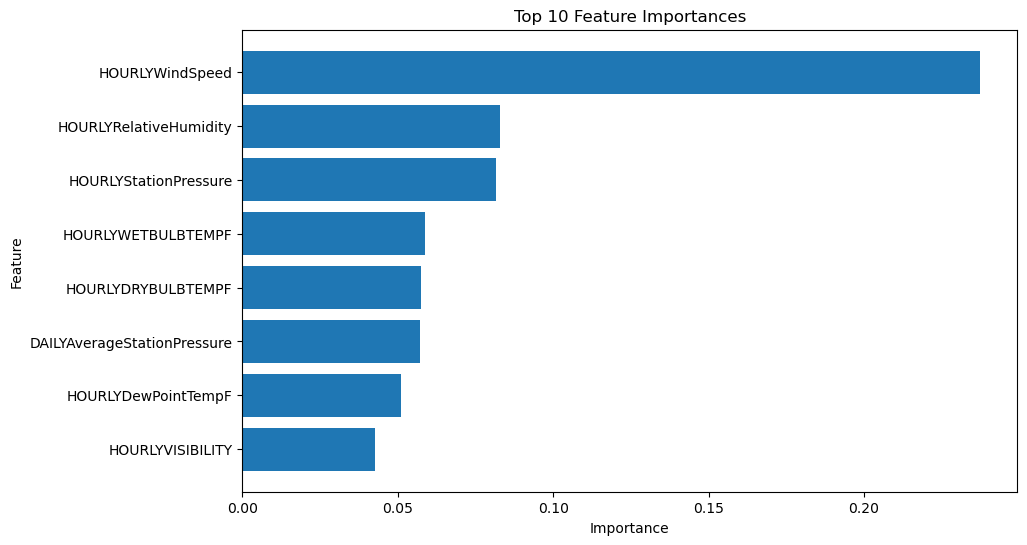

In [24]:
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X, y)

# We get the most important features
importances = rf_reg.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Then we select the most important features (example here the 8 most)
top_features = feature_importance_df.head(8)['Feature']
X_selected = X[top_features]


# This section is optionnal and only allows us to visualize the most important features
os.makedirs(output_dir, exist_ok=True)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'].head(8), feature_importance_df['Importance'].head(8))
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances")
plt.gca().invert_yaxis()  # Most important at the top


# Linear Regression
lin_reg = LinearRegression()
y_pred_lin = cross_val_predict(lin_reg, X_selected, y, cv=5)  # 5-fold cross-validation

# Random Forest
rf_reg = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)
y_pred_rf = cross_val_predict(rf_reg, X_selected, y, cv=5)

# XGBoost
xgb_reg = XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=5, random_state=42)
y_pred_xgb = cross_val_predict(xgb_reg, X_selected, y, cv=5)

# Metrics calculation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

results = {
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'MAE': [
        mean_absolute_error(y, y_pred_lin),
        mean_absolute_error(y, y_pred_rf),
        mean_absolute_error(y, y_pred_xgb)
    ],
    'RMSE': [
        sqrt(mean_squared_error(y, y_pred_lin)),
        sqrt(mean_squared_error(y, y_pred_rf)),
        sqrt(mean_squared_error(y, y_pred_xgb))
    ],
    'R^2': [
        r2_score(y, y_pred_lin),
        r2_score(y, y_pred_rf),
        r2_score(y, y_pred_xgb)
    ]
}


The feature importance plot provides insights into the factors contributing to departure delays.
**HOURLYWindSpeed** stands out as the **most important feature**, aligning with expectations since wind speed directly impacts flight schedules.
Other weather-related variables like HOURLYRelativeHumidity, HOURLYStationPressure also have notable contributions.
Interestingly, DAILYAverageStationPressure and HOURLYWETBULBTEMPF indicate that both daily and hourly weather metrics are relevant.
Even though our **predictive power is limited**, the feature importance highlights key weather variables, offering valuable insights into the relationship between weather conditions and delays.

The feature importance highlights key weather variables like wind speed and humidity, and the minimal delays caused by weather reflect the **technological advancements and robustness** of modern  aircraft in handling adverse conditions.


### Comparison of the models performances

In [25]:
print("\nComparison of Model Performance (PCA):")
print(results_df_PCA)

results_df_FI = pd.DataFrame(results)
print("\nComparison of Model Performance (Feature Importance):")
print(results_df_FI)


Comparison of Model Performance (PCA):
               Model        MAE        RMSE       R^2
0  Linear Regression  34.901565   81.801946 -0.212149
1      Random Forest  52.452017  106.145131 -1.040933
2            XGBoost  91.038144  211.860884 -7.130742

Comparison of Model Performance (Feature Importance):
               Model        MAE       RMSE       R^2
0  Linear Regression  26.279441  74.718620 -0.011315
1      Random Forest  31.654620  88.319349 -0.412994
2            XGBoost  32.876122  92.898499 -0.563313


### Interpretations

Feature Importance consistently provides better results compared to PCA, enhancing relevance and interpretability of the features used in the models.

---

**Model Observations**:
- **Linear Regression**:
  - Achieves the lowest MAE (26.28) and RMSE (74.72) among all models.
  - R² remains slightly negative (-0.011), indicating minimal explanatory power.  
  - Provides the most coherent and realistic predictions, making it the best choice for this dataset.

- **Random Forest**:
  - Improved performance with Feature Importance (MAE: 31.65, RMSE: 88.32) compared to PCA.
  - R² of -0.413 reflects poor generalization, with less consistent predictions than Linear Regression.

- **XGBoost**:
  - Demonstrates the highest errors (MAE: 32.88, RMSE: 92.90) and the lowest R² (-0.563), indicating weak overall performance.

---

### Key Observations:
1. **Feature Importance vs. PCA**:
   - Feature Importance enhances model focus on relevant features, reducing noise and improving interpretability.
   - All models show better performance when using Feature Importance over PCA.

2. **Model Selection**:
   - Linear Regression stands out for its low MAE and RMSE, even with limited explanatory power (low R²).
   - While predictions are not highly accurate, they are the most consistent and realistic.

3. **Limitations**:
   - Low R² values across all models indicate weak predictive power, emphasizing the challenges of predicting delays from weather data alone.
   - Few weather-related delays and minimal variance in data contribute to this limitation.

---

### Conclusion of the ML part:
Although the predictive power of the models is limited due to weak R² values, Linear Regression with Feature Importance emerges as the most consistent and interpretable choice. Through systematic experimentation, we identified a model configuration that aligns predictions with realistic expectations while minimizing overfitting.

To improve future iterations, incorporating seasonal penalties (e.g., higher delays in December) or additional contextual variables (e.g., airport congestion) could enhance model reliability and relevance.

## Part 4: Application
This app is in the App folder, but as long as its coding is in different files, we decided not to put it in the notebook, but you can see the corresponding files in the app folder. 

This Streamlit app allows users to search for flight information by entering a flight number and a date.

### Installation
Install dependencies and run the app via 2 lines in the next code cell

Then, you can access the app at the provided URL (we suggest the local URL).

### Usage
1. Enter the flight number (e.g., DL1708).
2. Select the flight date (today is selected by default).
3. View the flight details, weather forecast and delay prediction.

In [30]:
%pip install -r App/requirements.txt
!streamlit run App/app.py

Note: you may need to restart the kernel to use updated packages.



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8505
  Network URL: http://10.233.120.249:8505
  External URL: http://159.180.239.166:8505

^C
  Stopping...


## Conclusion